In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.simplefilter('ignore')

# Загрузка данных

In [2]:
source_train = pd.read_csv('train.csv')
source_test = pd.read_csv('test.csv')

In [3]:
print(source_train.shape)
source_train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print(source_test.shape)
source_test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Изучение и предобработка данных

In [8]:
source_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
source_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
source_train['keyword_true'] = source_train['keyword'].apply(lambda x: 0 if pd.isna(x) else 1)
source_test['keyword_true'] = source_test['keyword'].apply(lambda x: 0 if pd.isna(x) else 1)

source_train['keyword'] = source_train['keyword'].fillna('none')
source_test['keyword'] = source_test['keyword'].fillna('none')

source_train['location'] = source_train['location'].fillna('none')
source_test['location'] = source_test['location'].fillna('none')

source_train['text_len'] = source_train['text'].apply(lambda x: len(x))
source_test['text_len'] = source_test['text'].apply(lambda x: len(x))

source_train['http'] = source_train['text'].apply(lambda x: 'http' in x).astype(int)
source_test['http'] = source_test['text'].apply(lambda x: 'http' in x).astype(int)


In [11]:
def find_strange_locatoin(x):
    n=0
    for i in '!#$%?+=*&[]{}:;@^|\/-_':
        if i in x:
            n+=1
        
    return n
print(source_train.location.apply(lambda x: find_strange_locatoin(x)).sum())

780


In [12]:
source_train['strange_locatoin'] = source_train.location.apply(lambda x: find_strange_locatoin(x))
source_test['strange_locatoin'] = source_test.location.apply(lambda x: find_strange_locatoin(x))

In [13]:
def find_z(x, z):
    n = 0
    for i in x:
        if i == z:
            n+=1
    return n
    

In [14]:
for i in '!#$%?+:=;/*&.|[]':
    source_train[i] = source_train['text'].apply(lambda x: find_z(x, i))
    source_test[i] = source_test['text'].apply(lambda x: find_z(x, i))

In [15]:
def text_prep(text):
    text = ' '.join(text)
    text = text.lower()
    text.replace(',', '')
    text.replace('.', '')
    text = text.split()
    for n, i in enumerate(text):
        if 'http' in i:
            del text[n] 
    d = {}
    for i in text:
        if i in d:
            d[i]+=1
        else:
            d[i]=1
    return text, d

In [16]:
text_target_1 = source_train[source_train['target'] == 1]['text'].tolist()
text_target_1, d = text_prep(text_target_1)
text_target_1_unique = set(text_target_1)
text_date_target_1 = pd.DataFrame(columns = ['name', 'num'])
text_date_target_1['name'] = d.keys()
text_date_target_1['num'] = d.values()
text_date_target_1.sort_values('num', ascending=False)
text_date_target_1 = text_date_target_1[text_date_target_1['num']>50]
text_date_target_1.sort_values('num', ascending=False)

,name,num
3,the,1330
24,in,1144
5,of,919
54,a,897
22,to,753
...,...,...
1105,obama,52
799,it's,52
406,there,52
524,|,51


In [17]:
text_target_0 = source_train[source_train['target'] == 0]['text'].tolist()
text_target_0, d = text_prep(text_target_0)
text_target_0_unique = set(text_target_0)
text_date_target_0 = pd.DataFrame(columns = ['name', 'num'])
text_date_target_0['name'] = d.keys()
text_date_target_0['num'] = d.values()
text_date_target_0.sort_values('num', ascending=False)
text_date_target_0 = text_date_target_0[text_date_target_0['num']>50]
text_date_target_0.sort_values('num', ascending=False)

,name,num
43,the,1877
14,a,1238
48,to,1181
3,i,1052
93,and,911
...,...,...
723,even,51
1527,burning,51
442,really,51
411,because,51


In [18]:
razn = []
for i in text_date_target_1['name'].tolist():
    if i not in text_date_target_0['name'].tolist():
        razn.append(i)
print(razn)

['california', 'car', 'crash', 'two', 'police', 'fires', 'were', 'killed', '#news', 'dead', '...', 'storm', 'northern', 'nuclear', 'suicide', 'bombing', 'obama', 'news', 'atomic', 'war', 'bomb', 'hiroshima', 'families', 'train', 'disaster', 'homes', 'buildings', 'fatal', 'bomber']


In [19]:
def find_z_new(text, z):
    text = text.lower()
    text.replace(',', '')
    text.replace('.', '')
    text = text.split()
    n = 0
    for i in text:
        if i == z:
            n+=1
    return n



In [20]:
for i in razn:
    source_train[i] = source_train['text'].apply(lambda x: find_z_new(x, i))
    source_test[i] = source_test['text'].apply(lambda x: find_z_new(x, i))

# Данные

In [21]:
X = source_train.drop(['id', 'target', 'text','location'], axis=1)
y = source_train['target']
X_test = source_test.drop(['id','text','location'], axis=1)

In [22]:
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

In [23]:
X.head()

,keyword_true,text_len,http,strange_locatoin,!,#,$,%,?,+,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
0,0,69,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,133,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,65,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,88,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
for i in razn:
    print(f'{i} = {X[i].sum()}')
for i in '!#$%?+:=;/*&.|[]':
    print(f'{i} = {X[i].sum()}')

california = 91
car = 84
crash = 84
two = 96
police = 126
fires = 76
were = 106
killed = 95
#news = 72
dead = 81
... = 147
storm = 97
northern = 62
nuclear = 91
suicide = 109
bombing = 65
obama = 59
news = 80
atomic = 58
war = 85
bomb = 92
hiroshima = 61
families = 86
train = 85
disaster = 122
homes = 58
buildings = 89
fatal = 63
bomber = 61
! = 1173
# = 3403
$ = 44
% = 46
? = 3126
+ = 80
: = 6910
= = 53
; = 587
/ = 14585
* = 179
& = 457
. = 11696
| = 152
[ = 132
] = 131


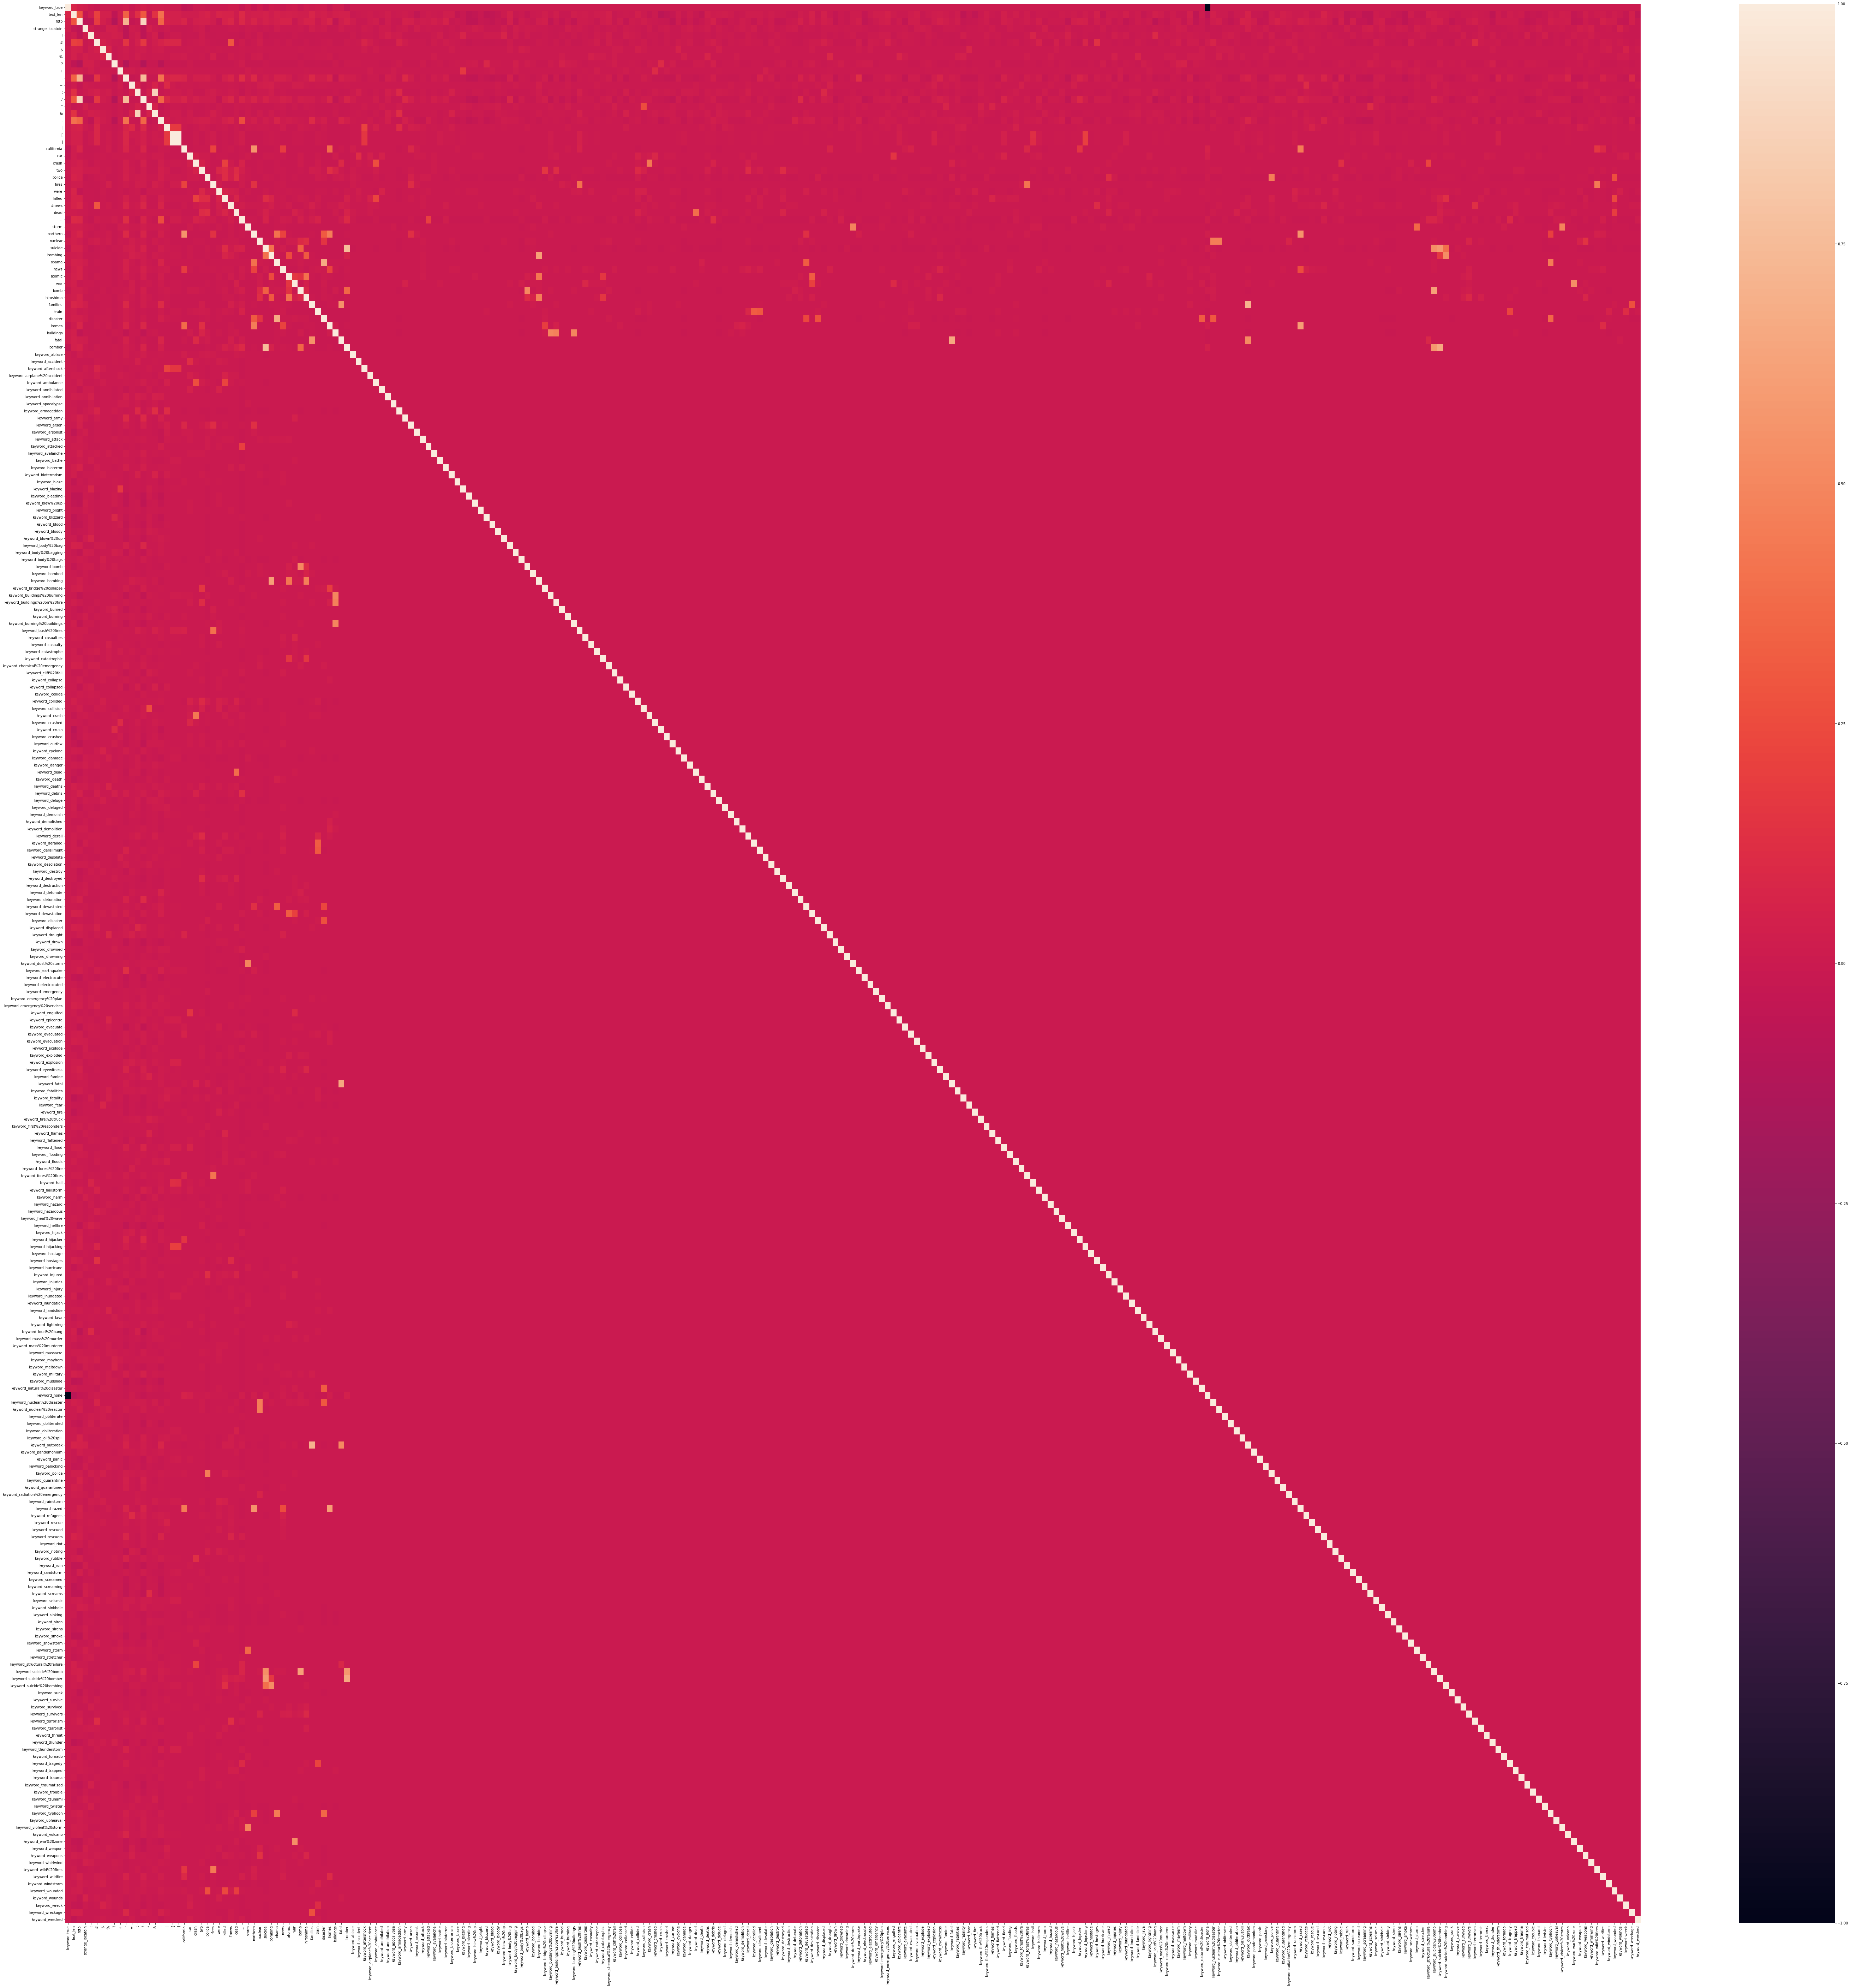

In [71]:
corrmat = X.corr()
f, ax = plt.subplots(figsize=(100,100))
sns.heatmap(corrmat);

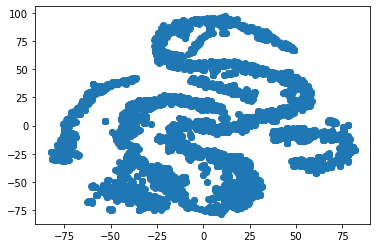

In [66]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=rs)
tsne.fit(X)
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1]);

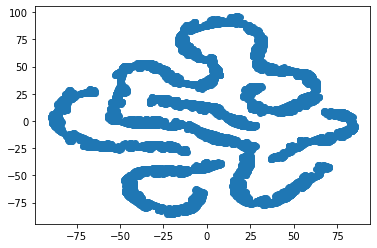

In [69]:
tsne.fit(source_train.drop(['keyword','location','text'], axis=1))
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1]);

<AxesSubplot:xlabel='text_len', ylabel='Count'>

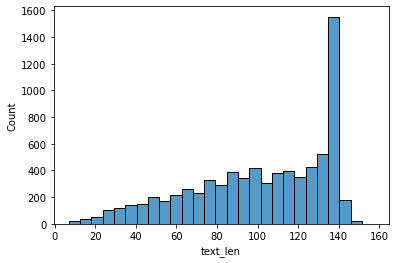

In [106]:
sns.histplot(X.text_len)

# Обучение

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

from sklearn import tree
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [30]:
rs = 50

## baseline_fit

In [31]:
clf_tree = tree.DecisionTreeClassifier(random_state = rs)
clf_log_reg = linear_model.LogisticRegression('l2')
clf_knn = KNeighborsClassifier()
clf_SVM = SVC()
clf_RF = RandomForestClassifier()
clf_NB = GaussianNB()

clf_tree_reg = tree.DecisionTreeRegressor(max_depth=5, random_state = rs)
clf_Ridge = linear_model.Ridge(alpha=1, random_state = rs)
clf_Lasso= linear_model.Lasso(alpha=1, random_state = rs)
clf_linear = linear_model.LinearRegression()

dict_clf = {clf_tree: True,
            clf_RF: True,
            clf_tree_reg: False,
            clf_Ridge: False,
            clf_Lasso: False,
            clf_linear: False,
            clf_knn: True,
            clf_SVM: True,
            clf_NB: True,
            clf_log_reg: True}

In [32]:
def baseline_fit(dict_clf, X_train, y_train, X_val, y_val, X, y):
    for i in dict_clf:
        if dict_clf[i]:
            try:
                i.fit(X, y)
                print(f'{i}')
#                 print(f'| score             {round(i.score(X_val, y_val), 3)} ')
                print(f'| cross_val_score   {round(np.mean(cross_val_score(i, X, y, cv=5)), 3)} ')
                print('-----------------------------------------\n')
            except:
                print(f'No - {i}')

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = rs)

In [34]:
for i in [X_train, X_val, y_train, y_val]:
    print(i.shape)

(5329, 271)
(2284, 271)
(5329,)
(2284,)


In [45]:
baseline_fit(dict_clf, X_train, y_train, X_val, y_val, X, y)

DecisionTreeClassifier(random_state=10)
| cross_val_score   0.585 
-----------------------------------------

RandomForestClassifier()
| cross_val_score   0.612 
-----------------------------------------

KNeighborsClassifier()
| cross_val_score   0.603 
-----------------------------------------

SVC()
| cross_val_score   0.585 
-----------------------------------------

GaussianNB()
| cross_val_score   0.524 
-----------------------------------------

LogisticRegression()
| cross_val_score   0.64 
-----------------------------------------



## DecisionTreeClassifier 0.643

In [69]:
params = {'criterion':('gini', 'entropy'), 
          'max_depth':range(20), 
          'min_samples_split':range(10)}
clf_tree = tree.DecisionTreeClassifier(random_state = rs)
clf_tree_GSCV = GridSearchCV(clf_tree, params, n_jobs=-1)
clf_tree_GSCV.fit(X, y)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 287, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: Fi

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/sit

GridSearchCV(estimator=DecisionTreeClassifier(random_state=50), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(0, 20),
                         'min_samples_split': range(0, 10)})

In [36]:
# best DecisionTreeClassifier
print(clf_tree_GSCV.best_params_)
print(clf_tree_GSCV.best_score_)

{'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 7}
0.6420644295139876


## RandomForestClassifier 0.653

In [70]:
params = {'max_depth':range(10),
          'n_estimators':range(100, 800, 100)}
clf_RF = RandomForestClassifier(random_state=rs)
clf_RF_GSCV = GridSearchCV(clf_RF, params, n_jobs=-1)
clf_RF_GSCV.fit(X, y)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/danilaandreev/opt/anaconda3/lib/pyt

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/danilaandreev/opt/anaconda3/lib/pyt

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/danilaandreev/opt/anaconda3/lib/pyt

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/danilaandreev/opt/anaconda3/lib/pyt

GridSearchCV(estimator=RandomForestClassifier(random_state=50), n_jobs=-1,
             param_grid={'max_depth': range(0, 10),
                         'n_estimators': range(100, 800, 100)})

In [31]:
# best RandomForestClassifier
print(clf_RF_GSCV.best_params_)
print(clf_RF_GSCV.best_score_)

{'max_depth': 9, 'n_estimators': 300}
0.6531002939595497


In [104]:
RF = clf_RF_GSCV.best_estimator_
RF.fit(X, y)
pred = stack.predict(X_test)
submission(pred, 'submission_4')

## KNeighborsClassifier 0.635

In [71]:
params = {'metric':['Euclidean', 'minkowski'],
          'n_neighbors':range(1, 300)}
clf_KNN = KNeighborsClassifier()
clf_KNN_GSCV = GridSearchCV(clf_KNN, params, n_jobs=-1)
clf_KNN_GSCV.fit(X, y)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. U

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Met

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in 

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in 

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. U

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. U

Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Met

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_

ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  Fi

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. U

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in 

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in 

ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  Fi

ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  Fi

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. U

ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  Fi

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in 

  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'Euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
se sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  warnings.warn("Estimator fit failed. The score on this train-test"
a3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['Euclidean', 'minkowski'],
                         'n_neighbors': range(1, 300)})

In [72]:
# best KNeighborsClassifier()
print(clf_KNN_GSCV.best_params_)
print(clf_KNN_GSCV.best_score_)

{'metric': 'minkowski', 'n_neighbors': 88}
0.6354968882738008


## SVC 0.603

In [73]:
params = {'kernel':['linear', 'poly']}
clf_SVM = SVC()
clf_SVM_GSCV = GridSearchCV(clf_SVM, params, n_jobs=-1)
clf_SVM_GSCV.fit(X, y)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'poly']})

In [74]:
# best SVC()
print(clf_SVM_GSCV.best_params_)
print(clf_SVM_GSCV.best_score_)

{'kernel': 'poly'}
0.6033162122962581


## LogisticRegression 0.631

In [75]:
params = {'penalty':['l1', 'l2']}
clf_Log_Reg = linear_model.LogisticRegression()
clf_Log_Reg_GSCV = GridSearchCV(clf_Log_Reg, params, n_jobs=-1)
clf_Log_Reg_GSCV.fit(X, y)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2']})

In [76]:
# best SVC()
print(clf_Log_Reg_GSCV.best_params_)
print(clf_Log_Reg_GSCV.best_score_)

{'penalty': 'l2'}
0.6312955186483555


## Stacking 0.68

In [99]:
from sklearn.ensemble import StackingClassifier

In [100]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=9)),
    ('tree', tree.DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)),
    ('knn', KNeighborsClassifier(n_neighbors=88, metric='minkowski')),
    ('NB', GaussianNB()),
    ('svc', SVC(kernel='poly')),
    ('clf_log_reg', linear_model.LogisticRegression('l2'))
    
]

stack = StackingClassifier(estimators=estimators, 
                           final_estimator=linear_model.LogisticRegression('l2'), 
                           n_jobs=-1)



In [68]:
cross_val_score(stack, X, y, cv=10)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

array([0.64435696, 0.74540682, 0.61548556, 0.69908016, 0.68068331,
       0.66754271, 0.66885677, 0.66228647, 0.71616294, 0.70039422])

In [70]:
np.mean([0.64435696, 0.74540682, 0.61548556, 0.69908016, 0.68068331,
         0.66754271, 0.66885677, 0.66228647, 0.71616294, 0.70039422])

0.680025592

In [102]:
stack.fit(X, y)
pred = stack.predict(X_test)
submission(pred, 'submission_3')

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

## Bagging 0.691

In [80]:
from sklearn.ensemble import BaggingClassifier

In [81]:
base_estimator=RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=9)
bagg = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, n_jobs=-1)
bagg.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=9,
                                                        n_estimators=300),
                  n_estimators=100, n_jobs=-1)

In [82]:
bagg.score(X_val, y_val)

0.686077057793345

In [101]:
bagg.fit(X, y)
pred = bagg.predict(X_test)
submission(pred, 'submission_2')

## Boosting 0.762

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [63]:
GBC = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000)

In [64]:
GBC.score(X_val, y_val)

0.707968476357268

In [46]:
cross_val_score(GBC, X, y, cv=5)

array([0.62836507, 0.50820749, 0.47537754, 0.58147175, 0.59395532])

In [65]:
%%time
GBC = GradientBoostingClassifier()
param = {'learning_rate':np.linspace(0.01, 0.1, 5),
         'n_estimators':[1000]}
GBC_GSCV = GridSearchCV(GBC, param, n_jobs=-1)
GBC_GSCV.fit(X, y)

CPU times: user 12.9 s, sys: 159 ms, total: 13 s
Wall time: 1min 12s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ]),
                         'n_estimators': [1000]})

In [66]:
print(GBC_GSCV.best_score_)
print(GBC_GSCV.best_params_)

0.6079148198926146
{'learning_rate': 0.01, 'n_estimators': 1000}


In [67]:
pred=GBC_GSCV.predict(X_test)
output_data = pd.DataFrame(columns=['id', 'target'])
output_data['id'] = list(source_test['id'])
output_data['target'] = pred
output_data.to_csv('submission_1', index=False)

# Finish

In [79]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=9)),
    ('tree', tree.DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)),
    ('knn', KNeighborsClassifier(n_neighbors=88, metric='minkowski')),
    ('NB', GaussianNB()),
    ('svc', SVC(kernel='poly')),
    ('clf_log_reg', linear_model.LogisticRegression('l2'),
    ('GBC', GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)))
    
]

stack = StackingClassifier(estimators=estimators, 
                           final_estimator=linear_model.LogisticRegression('l2'), 
                           n_jobs=-1)

In [46]:
stack.fit(X, y)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=9,
                                                       n_estimators=300)),
                               ('tree',
                                DecisionTreeClassifier(max_depth=15,
                                                       min_samples_split=5)),
                               ('knn', KNeighborsClassifier(n_neighbors=88)),
                               ('NB', GaussianNB()),
                               ('clf_log_reg', LogisticRegression(),
                                ('GBC',
                                 GradientBoostingClassifier(n_estimators=1000)))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [62]:
pred = stack.predict(X_test)

In [63]:
output_data = pd.DataFrame(columns=['id', 'target'])
output_data['id'] = list(source_test['id'])
output_data['target'] = pred

In [65]:
output_data.to_csv('submission_0', index=False)

In [68]:
def submission(pred, name):
    output_data = pd.DataFrame(columns=['id', 'target'])
    output_data['id'] = list(source_test['id'])
    output_data['target'] = pred
    output_data.to_csv(name, index=False)